# Posterior plots for Sinusoidal model

In [1]:
import numpy as np
import random
import bayesflow as bf
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy.stats import norm, gaussian_kde
from scipy.integrate import dblquad
from tensorflow.keras.layers import LSTM

C:\Users\henry\missingness2\bayesflow\bayesflow\trainers.py:26: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
# Model specification
n_obs=41
t_end=10
sigma=0.05
time_points = np.linspace(0, t_end, n_obs)

In [3]:
# Dataset 1 (n_missing = 15)
param_prior_1 = np.array([[0.2, -0.4]])
result_1 = [
    np.array(
        [
            -0.38822525, -0.07585579,  0.09875853,  0.42901483,  0.48185913,
             0.62969871,  0.6457469 ,  0.434365  ,  0.20191629, -0.12380711,
            -0.41445603, -0.71438838, -1.10485856, -1.23079156, -1.36338658,
            -1.44566409, -1.45376767, -1.25233028, -0.98761422, -0.76457333,
            -0.41138701, -0.06165886,  0.19041922,  0.33472721,  0.54920351,
             0.63987353,  0.52822556,  0.4772211 ,  0.0992428 , -0.08048652,
            -0.37974125, -0.6531358 , -1.05218318, -1.23381172, -1.34811474,
            -1.42620643, -1.39496478, -1.15792385, -0.91626909, -0.72581709,
            -0.34380109,
        ]
    ),
    np.array(
        [
            0,  1,  2,  3,  4,  5,  6,  9, 11, 13, 14, 16, 17, 19, 20, 24, 25,
            27, 28, 29, 30, 31, 33, 36, 37, 39,
        ]
    ),
    np.array(
        [
            0.  , 0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 2.25, 2.75, 3.25, 3.5 ,
            4.  , 4.25, 4.75, 5.  , 6.  , 6.25,
            6.75, 7.  , 7.25, 7.5 , 7.75,
            8.25, 9.  , 9.25, 9.75,
        ],
    ),
]

# Dataset 2 (n_missing = 20)
param_prior_2 = np.array([[0.95, 0.1]])
result_2 = [
    np.array(
        [
             0.0411556 ,  1.08346297,  0.2623786 , -0.92034164, -0.17167728,
             1.02610335,  0.54370587, -0.78445069, -0.52135847,  0.85621658,
             0.77392383, -0.61739495, -0.73033272,  0.55306994,  1.02138007,
            -0.28863467, -0.77016348,  0.38925967,  1.03721564,  0.0408748 ,
            -0.91261586, -0.00819852,  1.12443804,  0.37746972, -0.84010395,
            -0.32655636,  0.99065733,  0.55809712, -0.67683952, -0.53908892,
             0.76198376,  0.88392371, -0.56456167, -0.77304082,  0.58618039,
             0.99736459, -0.13568713, -0.96373333,  0.26542047,  1.05570096,
             0.07219064,
        ]
    ),
    np.array(
        [
            1,  4,  5,  7,  9, 12, 14, 15, 16, 19, 21, 22, 24, 26, 27, 28, 32,
            33, 36, 37, 38,
        ],
    ),
    np.array(
        [
            0.25, 1.  , 1.25, 1.75, 2.25, 3.  , 3.5 , 3.75, 4.  , 4.75, 5.25,
            5.5 , 6.  , 6.5 , 6.75, 7.  , 8.  , 8.25, 9.  , 9.25, 9.5,
        ],
    ),
]

param_priors = [param_prior_1, param_prior_2]
results = [result_1, result_2]

In [4]:
# Encode missing data
x_datas = []
for result in results:
    x_datas.append({})

    x_data = np.ones((1, n_obs, 2), dtype=np.float32)
    x_data[0, :, 0] = result[0]
    missing_indices = np.setdiff1d(range(n_obs), result[1])
    x_data[0][missing_indices] = np.array([-5.0, 0.0])
    x_datas[-1]["augment01_lstm"] = x_data
    x_datas[-1]["augment01_trafo"] = x_data
    
    n_present = len(result[1])
    x_data = np.ones((1, n_present, 2), dtype=np.float32)
    x_data[0, :, 0] = result[0][result[1]]
    x_data[0, :, 1] = result[2]
    x_datas[-1]["timelabels_lstm"] = x_data
    x_datas[-1]["timelabels_trafo"] = x_data

In [5]:
# Postprocess the data such that it can be passed into the amortizer
for x_data_ix, x_data in enumerate(x_datas):
    for amortizer_id, data in x_data.items():
        x_data[amortizer_id] = {'parameters': param_priors[x_data_ix].astype(np.float32),
                                'summary_conditions': data.astype(np.float32),
                                'direct_conditions': None}

In [6]:
# Load trained networks
ckpts = {"augment01_lstm": './Osc_augment01_LSTM(128)_ckpts', "augment01_trafo": './Osc_augment01_trafo_ckpts',
         "timelabels_lstm": './Osc_timelabels_unnormalized_LSTM(128)_ckpts', "timelabels_trafo": './Osc_timelabels_unnormalized_trafo_ckpts'}
amortizers = {}

for ckpt_id, ckpt in ckpts.items():
    if ckpt_id=="augment01_lstm" or ckpt_id=="timelabels_lstm":
        summary_net = LSTM(128)
    else:
        summary_net = bf.networks.TimeSeriesTransformer(
                input_dim=2, 
                attention_settings=dict(num_heads=2, key_dim=16),
                dense_settings=dict(units=64, activation='relu'),
                )
    inference_net = bf.networks.InvertibleNetwork(num_params=2, num_coupling_layers=4)
    amortizer = bf.amortizers.AmortizedPosterior(inference_net, summary_net)
    trainer = bf.trainers.Trainer(amortizer=amortizer, checkpoint_path = ckpt)
    amortizers[ckpt_id] = amortizer

INFO:root:Trainer initialization: No generative model provided. Only offline learning mode is available!
INFO:root:Loaded loss history from ./Osc_augment01_LSTM(128)_ckpts\history_300.pkl.
INFO:root:Loaded simulation memory from ./Osc_augment01_LSTM(128)_ckpts\memory.pkl
INFO:root:Networks loaded from ./Osc_augment01_LSTM(128)_ckpts\ckpt-300
INFO:root:Trainer initialization: No generative model provided. Only offline learning mode is available!
INFO:root:Loaded loss history from ./Osc_augment01_trafo_ckpts\history_300.pkl.
INFO:root:Loaded simulation memory from ./Osc_augment01_trafo_ckpts\memory.pkl
INFO:root:Networks loaded from ./Osc_augment01_trafo_ckpts\ckpt-300
INFO:root:Trainer initialization: No generative model provided. Only offline learning mode is available!
INFO:root:Loaded loss history from ./Osc_timelabels_unnormalized_LSTM(128)_ckpts\history_300.pkl.
INFO:root:Loaded simulation memory from ./Osc_timelabels_unnormalized_LSTM(128)_ckpts\memory.pkl
INFO:root:Networks loade

In [7]:
# Sample from BayesFlow
samples = []
n_post_samples = 7500
    
for x_data in x_datas:
    samples.append({})
    for amortizer_id, amortizer in amortizers.items():
        samples[-1][amortizer_id] = amortizer.sample(x_data[amortizer_id], n_post_samples)

In [8]:
# Calculate integration boundaries
bounds = []
for dct in samples:
    param_samples = dct["augment01_lstm"]
    mean_sample = np.mean(param_samples, axis=0)
    cov_sample = np.cov(param_samples.transpose())
    mean_x = mean_sample[0]
    mean_y = mean_sample[1]       
    std_x = np.sqrt(cov_sample[0, 0])
    std_y = np.sqrt(cov_sample[1, 1])
    lb_x = mean_x - 6*std_x
    ub_x = mean_x + 6*std_x
    lb_y = mean_y - 6*std_y
    ub_y = mean_y + 6*std_y
    bounds.append([(lb_x, ub_x), (lb_y, ub_y)])

## Posterior plot

In [9]:
# Calculate analytical posteriors
def get_posterior(result, bounds):
    [(lb_x, ub_x), (lb_y, ub_y)] = bounds

    def prior_eval(a,b):
        # Evaluates prior probability p(theta) according to a ~ U(0.1, 1) & shift parameter b ~ N(0, 0.25²)
        if a > 0.1 and a < 1.0:
            return 1/0.9 * norm.pdf(b, 0.0, 0.25)
        else: 
            return 0.

    def likelihood(a,b):   
        # Calculates likelihood of available data
        residual = (result[0][result[1]] - (np.sin(a*2*np.pi*result[2]) + b))/sigma
        nllh = np.sum(np.log(2*np.pi*sigma**2)+residual**2)/2
        return np.exp(-nllh)

    def unnormalized_posterior(a,b):   
        # Evaluates the unnormalized posterior probability according to Bayes' formula
        return likelihood(a,b) * prior_eval(a,b)

    # scaling factor
    scaling_factor = dblquad(unnormalized_posterior, lb_y, ub_y, lambda y: lb_x, lambda y: ub_x)

    posterior = lambda x,y: unnormalized_posterior(x,y) / scaling_factor[0]
    return posterior

posteriors = []
for result_ix, result in enumerate(results):
    posteriors.append({})
    for amortizer_id, param_samples in samples[result_ix].items():
        _bounds = bounds[result_ix]
        posteriors[-1][amortizer_id] = get_posterior(result, _bounds)

In [10]:
cmap = "viridis"
amortizer_labels = {"augment01_lstm": "Augment by 0/1 (LSTM(128))", "augment01_trafo": "Augment by 0/1 (transformer)",
                    "timelabels_lstm": "Time labels (LSTM(128))", "timelabels_trafo": "Time labels (transformer)"}

def plot_posterior(ax, posterior, param_samples, amortizer_id, result_ix, levels=None):
    # Level sets of analytic posterior distribution
    grid = 101
    if result_ix==0:
        A = np.linspace(0.198, 0.201, grid)
        B = np.linspace(-0.44, -0.37, grid)
    else: 
        A = np.linspace(0.948, 0.952, grid)
        B = np.linspace(0.06, 0.14, grid)
    true_posterior = np.zeros((grid, grid))
    for iy in range(0, grid):
        for ix in range(0, grid):
            true_posterior[iy][ix] = posterior(A[ix], B[iy])   
    _cs = ax.contour(A, B, true_posterior, cmap=cmap)
    
    # Kernel density estimator of BayesFlow samples
    a = param_samples[:, 0]
    b = param_samples[:, 1]
    ab = np.vstack([a, b])
    z = gaussian_kde(ab)(ab)
    ida = z.argsort()  # Sort the points by density, so that the densest points are plotted last
    a, b, z = a[ida], b[ida], z[ida]
    approximate_posterior = ax.scatter(a, b, c=z, s=10, cmap=cmap, alpha=0.1)

    ax.set_xlabel('Parameter $a$')
    ax.set_ylabel('Parameter $b$')
    ax.set_title(amortizer_labels[amortizer_id])

## Posterior predictive check

In [11]:
# Posterior predictive check
grid = 501
time_line = np.linspace(0, 10, grid)

def plot_predictive_check(ax, param_prior, result, param_samples, n_sim=1000):
    
    traj_sim = np.empty((n_sim, grid))
    
    for k in range(n_sim):
        a = param_samples[k, 0]   # frequency
        b = param_samples[k, 1]   # shift    
        traj_sim[k] = np.sin(a*2*np.pi*time_line) + b + np.random.normal(0, sigma, size=grid)
    
    traj_mean = np.mean(traj_sim, axis=0)
    traj_quantiles = np.quantile(traj_sim, [0.05, 0.95], axis=0)
    ax.plot(time_line, traj_mean, color='tab:orange', label='Simulated mean')
    ax.fill_between(time_line, traj_quantiles[0], traj_quantiles[1], color='tab:orange', alpha=.3, label='90% CI')
    
    a = param_prior[0, 0]   # frequency
    b = param_prior[0, 1]   # shift   
    ax.plot(time_line, np.sin(a*2*np.pi*time_line) + b, color='black', linestyle="dashed", label='True trajectory')    
    
    present_indices = result[1]
    missing_indices = np.setdiff1d(range(n_obs), present_indices)
    ax.plot(time_points[present_indices], result[0][present_indices], 'o', markersize=4.25, label='Available data')
    ax.set_title(amortizer_labels[amortizer_id])
    ax.set_xlabel('Time $t$')
    ax.set_ylabel("Measurement $y$")

## Combined plot

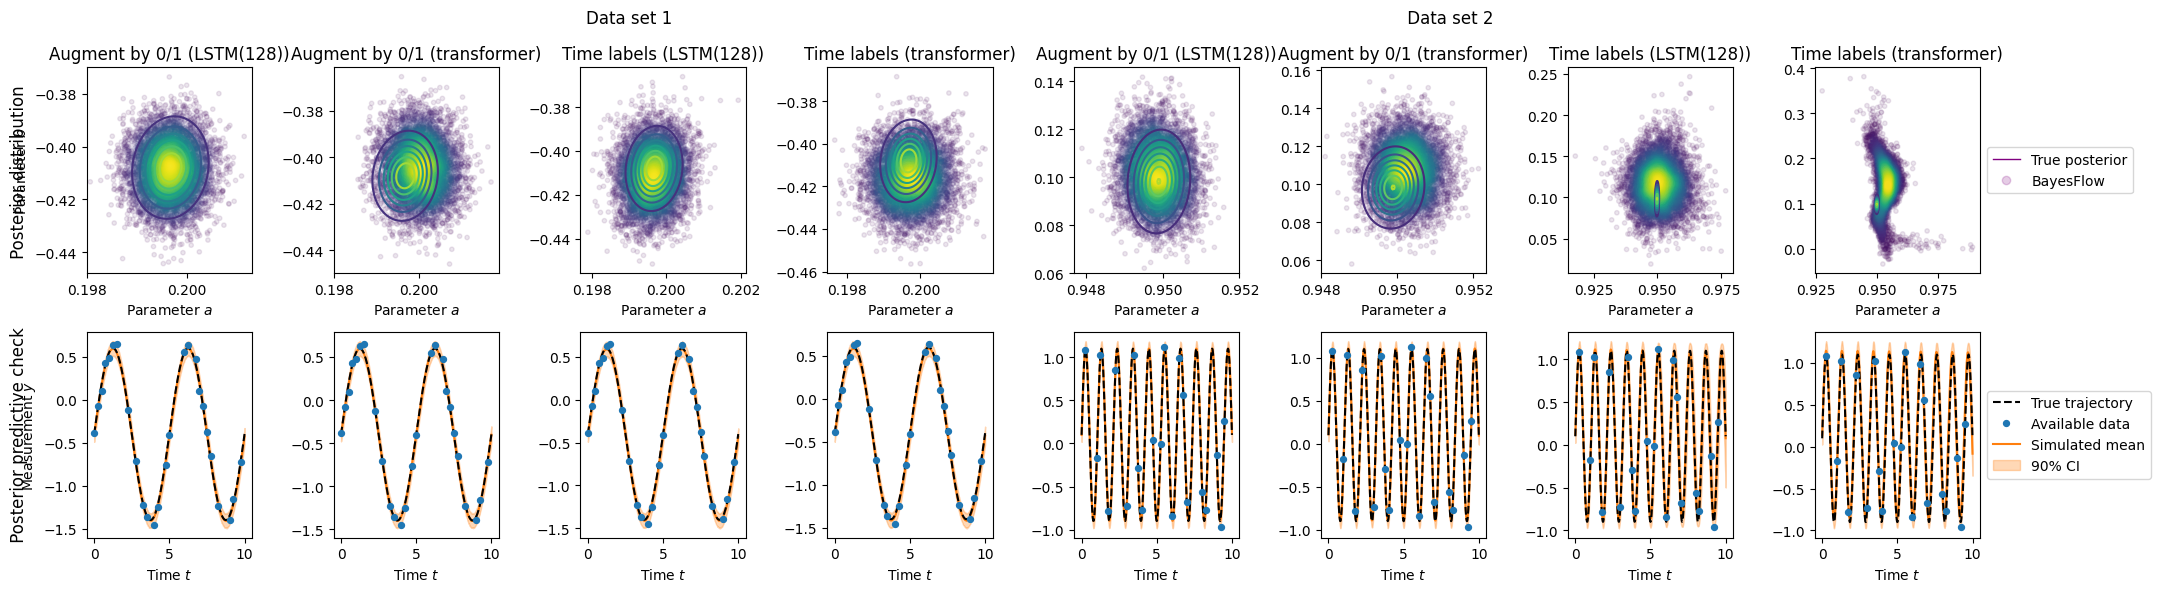

In [12]:
fig, axes_all = plt.subplots(2, 8, figsize=(22, 6))

axes = axes_all[0, :]
for result_ix, result in enumerate(results):
    for amortizer_ix, (amortizer_id, amortizer) in enumerate(amortizers.items()):
        posterior = posteriors[result_ix][amortizer_id]
        param_samples = samples[result_ix][amortizer_id]
        
        ax = axes[result_ix * 4 + amortizer_ix]
        plot_posterior(ax, posterior, param_samples, amortizer_id, result_ix)
        if result_ix > 0 or amortizer_ix > 0:
            ax.set_ylabel(None)
            
# Legend
legend_elements = [
    Line2D([0], [0], color="purple", lw=1, label="True posterior"),
    Line2D([0], [0], color="purple", markerfacecolor="purple", marker="o", lw=0, markersize=6, alpha=0.2, label="BayesFlow"),
]
axes[-1].legend(handles=legend_elements, loc="center left", bbox_to_anchor=(1, 0.5))

axes = axes_all[1, :]
for result_ix, (param_prior, result) in enumerate(zip(param_priors, results)):
    for amortizer_ix, (amortizer_id, amortizer) in enumerate(amortizers.items()):
        param_samples = samples[result_ix][amortizer_id]
        ax = axes[result_ix * 4 + amortizer_ix]
        plot_predictive_check(ax, param_prior, result, param_samples)
        if result_ix > 0 or amortizer_ix > 0:
            ax.set_ylabel(None)
        ax.set_title(None)

# Legend
handles, labels = axes[-1].get_legend_handles_labels()
order = [2,3,0,1]
axes[-1].legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc="center left", bbox_to_anchor=(1,0.5))


fig.suptitle("Data set 1                                                                                                                                            Data set 2          ")
fig.supylabel(" Posterior predictive check             Posterior distribution       ")

fig.tight_layout()
for fmt in ["png", "pdf"]:
    fig.savefig(f"figures/Sin_posteriors_new.{fmt}", dpi=300, bbox_inches='tight')